# Imports

In [61]:
from sympy.solvers import solve,nsolve
from sympy import Symbol
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
from multiprocessing import Pool
import scienceplots
plt.style.use("science")

# The Circuit

The circuit is as follows:
![](./images/simple-circuit.jpg)

The state variable is the current through the resistor.The measurement equation is as follows:
$$
\begin{cases}
    Z_1 = x+v_1\\
    Z_2 = R x+v_2\\
    Z_3 = R x^2+v_3\\
\end{cases}
$$
where $x$ is the state variable, $v_i$ is the measurement noise, and $Z_i$ is the measurement value.

Taking the p.u. values, we have:
$$
\begin{cases}
    Z_1 = x+v_1\\
    \frac{Z_2}{R} = x+v_2\\
    \frac{Z_3}{R^2} = x^2+v_3\\
\end{cases}
$$





Plug in the measurement values, we have:
$$
\begin{cases}
    1.05 = x+v_1\\
    0.98 = x+v_2\\
    0.96 = x^2+v_3\\
\end{cases}
$$

For a least square without weighting, the target function is:
$$
J(x) = (1.05 - x)^2 + (0.98 - x)^2 + (0.96 - x^2)^2
$$
For weighted least square, the target function is:
$$
J(x) = w_0(1.05 - x)^2 + w_1(0.98 - x)^2 + w_2(0.96 - x^2)^2
$$
where $w_i=\frac{1}{\sigma_i^2}$.




# Initialization

In [62]:
# Create a dictionary to store all the parameters
data = {
    'means': {
        0: 1.0,
        1: 1.0,
        2: 1.0
    },
    'stds': {
        0: 0.05,
        1: 0.02,
        2: 0.01
    },
    'measurements': {
        0: 1.05,
        1: 0.98,
        2: 0.96
    }
    # Values here are p.u. values.
}
data['weights'] = {i: 1 / data['stds'][i]**2 for i in range(3)}
# generate certain number sets of measurements
no_sets=10000
# set the random seed of numpy
np.random.seed(42)
data['mc_measurements'] = {
    0: np.random.normal(data['means'][0], data['stds'][0], no_sets),
    1: np.random.normal(data['means'][1], data['stds'][1], no_sets),
    2: np.random.normal(data['means'][2], data['stds'][2], no_sets)
}

# State Estimation Example

## Least Squares 2 Measurements 

In [63]:
x = Symbol('x',real=True)
x_hat_ls_2=nsolve(-2*(data['measurements'][0]-x)-2*(data['measurements'][1]-x), x,1)

In [64]:
x_hat_ls_2

1.01500000000000

## LS 3 measurements

In [65]:
x_hat_ls_3=nsolve(-2*(data['measurements'][0]-x)-2*(data['measurements'][1]-x)-4*x*(data['measurements'][2]-x**2), x,1)

In [66]:
x_hat_ls_3

0.991708661552310

## WLS 2 measurements (Weighted Least Squares)

In [67]:
x_hat_wls_2=nsolve(-2*data['weights'][0]*(data['measurements'][0]-x)-2*data['weights'][1]*(data['measurements'][1]-x), x,1)

In [68]:
x_hat_wls_2

0.989655172413793

## WLS 3 measurements (Weighted Least Squares)

In [69]:
x_hat_wls_3=nsolve(-2*data['weights'][0]*(data['measurements'][0]-x)-2*data['weights'][1]*(data['measurements'][1]-x)-4*data['weights'][2]*x*(data['measurements'][2]-x**2), x,1)
x_hat_wls_3

0.980487513858790

# Monte Carlo simulation

<Axes: ylabel='Count'>

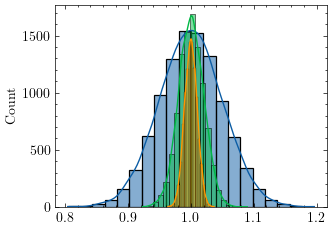

In [70]:
# check the distribution of the measurements
sns.histplot(data['mc_measurements'][0],bins=20,kde=True)
sns.histplot(data['mc_measurements'][1],bins=20,kde=True)
sns.histplot(data['mc_measurements'][2],bins=20,kde=True)

## WSL 2 Measurements

In [71]:
w0=data['weights'][0]
w1=data['weights'][1]
w2=data['weights'][2]
mc_m0=data['mc_measurements'][0]
mc_m1=data['mc_measurements'][1]
mc_m2=data['mc_measurements'][2]

In [72]:
def solve_single_estimate_wsl_2(i):
    x = Symbol('x')
    try:
        x_hat = nsolve(-2*w0*(mc_m0[i]-x)-2*w1*(mc_m1[i]-x), x, 1)
        return float(x_hat)
    except:
        return None

In [73]:
if __name__ == '__main__':
    # Number of processes - usually set to number of CPU cores
    num_processes = 12  # adjust this based on your CPU
    
    # Create the pool of workers
    with Pool(processes=num_processes) as pool:
        results = pool.map(solve_single_estimate_wsl_2, range(no_sets))
    x_mc_estimates_wsl_2 = [x for x in results if x is not None]

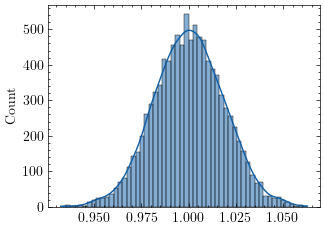

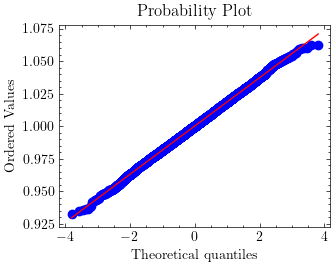

In [74]:
# plot the distribution of the estimates, with the kde. 
sns.histplot(x_mc_estimates_wsl_2,kde=True)
plt.show()
# use the Q-Q plot to check if the distribution is Gaussian
#Q-Q plots plot the data against a specified distribution. 
probplot(x_mc_estimates_wsl_2,dist='norm',plot=plt)
plt.show()

## WSL 3 Measurements

In [75]:
def solve_single_estimate_wsl_3(i):
    x = Symbol('x')
    try:
        x_hat = nsolve(-2*w0*(mc_m0[i]-x)-2*w1*(mc_m1[i]-x)-4*w2*x*(mc_m2[i]-x**2), x, 1)
        return float(x_hat)
    except:
        return None

In [76]:
# Initialize the parallel processing
if __name__ == '__main__':
    # Number of processes - usually set to number of CPU cores
    num_processes = 12  # adjust this based on your CPU
    
    # Create the pool of workers
    with Pool(processes=num_processes) as pool:
        # Map the function to all indices
        results = pool.map(solve_single_estimate_wsl_3, range(no_sets))
    
    # Filter out None values (failed solutions) and convert to list
    x_mc_estimates_wsl_3 = [x for x in results if x is not None]

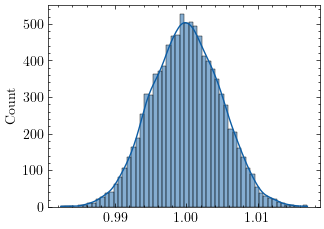

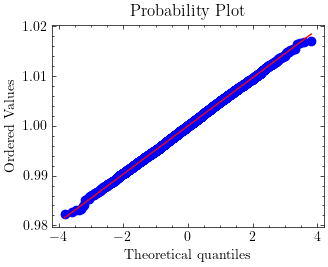

In [77]:
# plot the distribution of the estimates, with the kde. 
sns.histplot(x_mc_estimates_wsl_3,kde=True)
plt.show()
# use the Q-Q plot to check if the distribution is Gaussian
#Q-Q plots plot the data against a specified distribution. 
probplot(x_mc_estimates_wsl_3,dist='norm',plot=plt)
plt.show()